In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
import os
from pathlib import Path
from tqdm import tqdm
from hyperopt import fmin, tpe, hp, anneal, Trials
from sklearn.metrics import f1_score
import pandas as pd

In [5]:
import cv2
from fastai import *
from fastai.vision import *

from dataset_spliter import SplitByPatient
from metrics import *#F1Weighted, MCC
from losses import *
from augmentation import cutout

In [6]:
path = Path('/data/Datasets/WhiteBloodCancer/train/')

In [7]:
np.random.seed(42)

In [8]:
fnames = get_image_files(path, recurse=True)
pat = re.compile(r'^.*(hem|all).bmp$')

In [9]:
size = 224
bs = 96

In [10]:
data  = (ImageDataBunch.from_name_re(path, fnames, pat, size=size, bs=bs, valid_pct=0.1)).normalize()

In [11]:
from torch.autograd import Variable

def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels.data.cpu()]

class FocalLoss(nn.Module):
    def __init__(self, num_classes, alpha=0.25, gamma=1.):
        super().__init__()
        self.num_classes = num_classes
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, pred, targ, reduction='none'):
        t = one_hot_embedding(targ, self.num_classes + 1)
        t = Variable(t[:, :-1].contiguous()).cuda()  # .cpu()
        x = pred[:, :-1]
        w = Variable(self.get_weight(x, t))
        return F.binary_cross_entropy_with_logits(x, t, w, size_average=False) / self.num_classes

    def get_weight(self,x,t):
        p = x.sigmoid()
        pt = p*t + (1-p)*(1-t)
        w = self.alpha*t + (1-self.alpha)*(1-t)
        return w * (1-pt).pow(self.gamma)

In [28]:
def optimise_focal_loss(params, random_state=42):
    
    np.random.seed(random_state)
    
    a = params['alpha']
    g = params['gamma']

    tfms = get_transforms(do_flip=True, 
                      flip_vert=True, 
                      max_rotate=90,  
                      max_lighting=0.15, 
                      max_zoom=1.5, 
                      max_warp=0.2,
                      p_affine=0.75,
                      p_lighting=0.75,  
                     )
    
    learn = create_cnn(data, models.resnet34, 
                   metrics=[error_rate],  
                   loss_func=FocalLoss(num_classes=1, alpha=a, gamma=g),
                   #callbacks = [TerminateOnNaNCallback()],
                   callback_fns=[partial(SaveModelCallback, monitor="error_rate", mode='min', name='opti_test')],
                  ).mixup().to_fp16()
    
    lr = 1e-2
    learn.fit_one_cycle(4, lr)
    
    preds, y = learn.get_preds()
    preds = preds.argmax(1)
    
    return 1 - f1_score(to_np(preds), to_np(y))

In [32]:
# possible values of parameters
space={
    'alpha': hp.quniform('alpha', 0.1, 1, 0.1),
    'gamma' : hp.quniform('gamma', 0.1, 1, 0.1),
}

In [33]:
trials = Trials()

In [34]:
n_iter = 16*4 #16 gleich eine stunde

In [35]:
%%time

best=fmin(fn=optimise_focal_loss, # function to optimize
          space=space, 
          algo=tpe.suggest, # optimization algorithm, hyperotp will select its parameters automatically
          max_evals=n_iter, # maximum number of iterations
          trials=trials, # logging
          rstate=np.random.RandomState(42) # fixing random state for the reproducibility
         )

CPU times: user 6h 52min, sys: 2h 35min 28s, total: 9h 27min 29s
Wall time: 9h 40min 27s


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1fe24e7390>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f1fe1c90f98>], dtype=object)

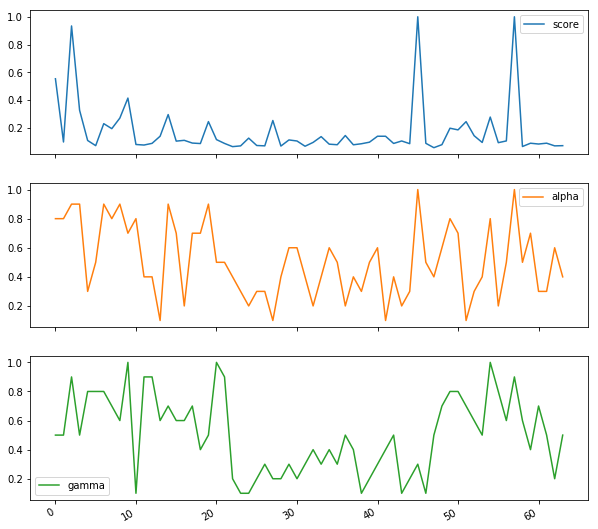

In [36]:
sa_results=np.array([[x['result']['loss'],
                      x['misc']['vals']['alpha'][0],
                      x['misc']['vals']['gamma'][0],                    
                     ] for x in trials.trials])

sa_results_df=pd.DataFrame(sa_results,
                           columns=['score', 'alpha', 'gamma'])
sa_results_df.plot(subplots=True,figsize=(10, 10))

In [38]:
best

{'alpha': 0.4, 'gamma': 0.5}